# Kaggle class competition
# Deep Learning and Neural Network Models to predict traffic volume
# Models: LSTM, GRUs
# Library used: Tensorflow, Keras

### Set Up Libraries

In [70]:
# ns - as typically happens, outdated components like as keywords, functions, and classes trigger a warning.
import warnings
warnings.filterwarnings('ignore')
# ns - below are the neccessary packages utilized in this project
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Import data

In [2]:
# ns - use pandas package to read in data from file located within folder 
data = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### Inspect and Clean up

In [3]:
# ns - investigate the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


#### It could be seen that there are both str and num types of data as categorized below
categorical features: holiday, weather_main, weather_description

Continious features: temp, rain_1h, show_1h, clouds_all

Target: traffic_volume

### Convert date_time column to datetime type

It is usable if we don't convert string type to datetime type in this project. It is due to the fact that time series will absolutely need datetime. So below is the demonstration.

In [4]:
# ns - datetime type conversion
date_time = pd.to_datetime(data.pop('date_time'), format='%Y-%m-%d %H:%M:%S')

### Convert to a usable signal 

In this form of signal, we would be able to utilize its capacity in the ultimate way as it reveals more insignhts as illjustrated below. 

In [5]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [6]:
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

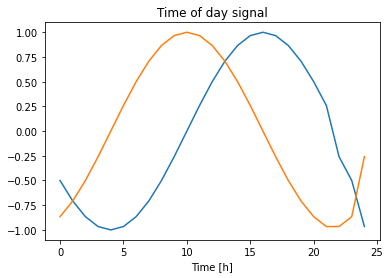

In [7]:
plt.plot(np.array(data['Day sin'])[:25])
plt.plot(np.array(data['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

The best way to identify which frequencies are most essential is to use a "fft". As a preliminary test, below is the traffic volume rfft experiment. While we're discussing common frequencies, it's interesting to note the highs at 1/year and 1/day frequencies:

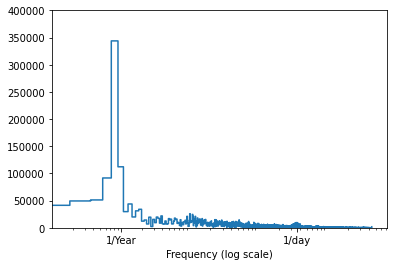

In [8]:
fft = tf.signal.rfft(data['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(data['temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Drop variable "weather_description" and convert "holiday" and "weather_main" to dummies variables

It is assumed that the weather description might be more irrelevant to this project or its interpretation could benefit less. Thus, I have decided to drop it. While both weather main and the holiday are deemed significant.

In [9]:
# ns - considered to drop some variable and generate dummies variables for the rest of obj type
data.drop('weather_description', axis=1, inplace=True)
data = pd.get_dummies(data, columns = ['holiday', 'weather_main'], drop_first=True)
data.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos,holiday_Columbus Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,5545,-0.500000,-8.660254e-01,-0.999682,0.025224,0,...,1,0,0,0,0,0,0,0,0,0
1,289.36,0.0,0.0,75,4516,-0.707107,-7.071068e-01,-0.999663,0.025941,0,...,1,0,0,0,0,0,0,0,0,0
2,289.58,0.0,0.0,90,4767,-0.866025,-5.000000e-01,-0.999645,0.026658,0,...,1,0,0,0,0,0,0,0,0,0
3,290.13,0.0,0.0,90,5026,-0.965926,-2.588190e-01,-0.999625,0.027374,0,...,1,0,0,0,0,0,0,0,0,0
4,291.14,0.0,0.0,75,4918,-1.000000,5.575167e-13,-0.999605,0.028091,0,...,1,0,0,0,0,0,0,0,0,0


### Split the data

In [10]:
# ns - as indicated in the instruction, the test set should be excluded with the size of 5000 ea.
# ns - the slicing method is used in this data split
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
print("There are ", n, "records and divisions are as below")

test_df = data[-5000:]
print("Test set: ", test_df.shape)

val_df = data[-13000:-5000]
print("Validation set: ", val_df.shape)

train_df = data[0:-13000]
print("Training set: ", train_df.shape)

num_features = data.shape[1]

There are  48204 records and divisions are as below
Test set:  (5000, 30)
Validation set:  (8000, 30)
Training set:  (35204, 30)


### Data Normalization

In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Data windowing

The models in this project will make a set of predictions based on a window of consecutive samples from the data and below is the useful windowgenerator class for segmenting data as required for modelling.

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

As per required, the windowgenerator here will provide 6 width with 2 future prediction and 1 label.

In [13]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=2,
                     label_columns=['traffic_volume'])
w2

Total window size: 8
Input indices: [0 1 2 3 4 5]
Label indices: [7]
Label column name(s): ['traffic_volume']

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### Note: 

Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

In [15]:
# ns - I tried with other stack but it failed to corporate with the model
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 8, 30)
Inputs shape: (3, 6, 30)
labels shape: (3, 1, 1)


### Plot 

#### Here is a plot method that allows a simple visualization of the split window

In [16]:
w2.example = example_inputs, example_labels

In [17]:
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

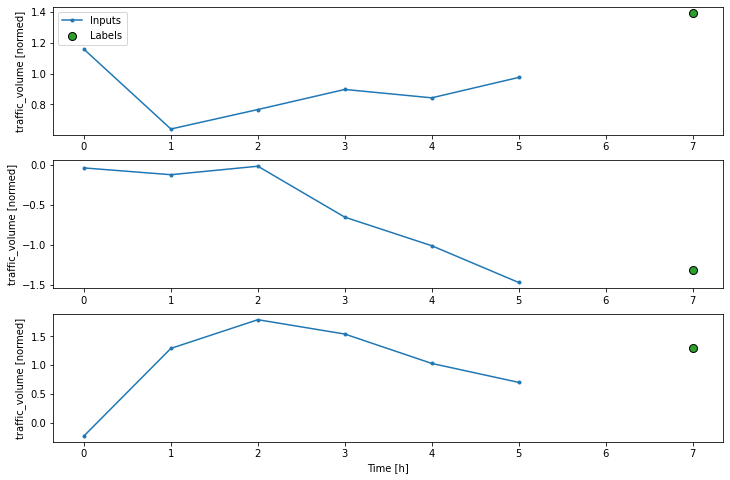

In [18]:
w2.plot()

The plots above illustrate the 6 inputs and 1 label as we defined them ealier. 

### Create tf.data.Datasets

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

### Note:

This make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function. The WindowGenerator object holds training, validation and test data. Add properties for accessing them as tf.data.Datasets using the above make_dataset method.

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 30), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

#### Iterating over a Dataset yields concrete batches:

In [22]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 30)
Labels shape (batch, time, features): (32, 1, 1)


#### This project trains many models, so package the training procedure into a function

In [23]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

For the multi-step model, the training data consists of hourly samples. However, here, the models will learn to predict 2h of the future, given 6h of the past. Here is a Window object that generates these slices from the dataset.

Total window size: 8
Input indices: [0 1 2 3 4 5]
Label indices: [6 7]
Label column name(s): None

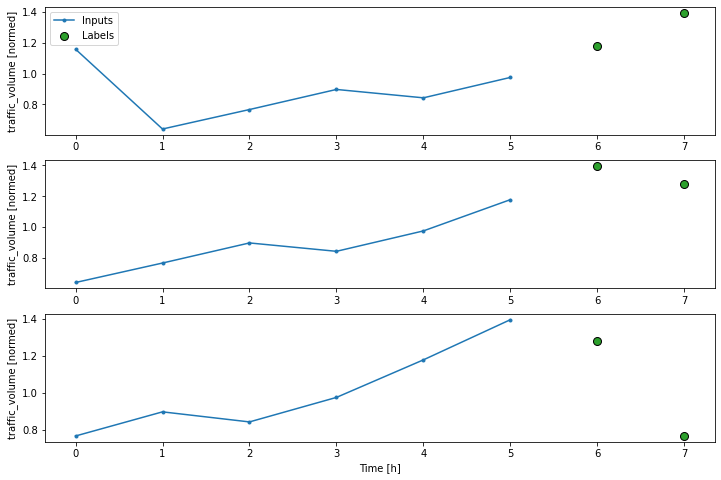

In [24]:
# ns - indicating the 2 hours future output from the 6 hours history input
OUT_STEPS = 2
multi_window = WindowGenerator(input_width=6,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Illustration here displays the 6 inputs with 2 hours prediction in the future.

### Model Construction
#### (1) The Base LSTM model

This model is expected to be used as the baseline model in this project. The error is aimed to be minimized in further steps. The architecture of this base model consists of LSTM layer with 32 unit, Dense layer and then reshape respectively.

250/250 [==============================] - 0s 2ms/step - loss: 0.7048 - mean_absolute_error: 0.1862


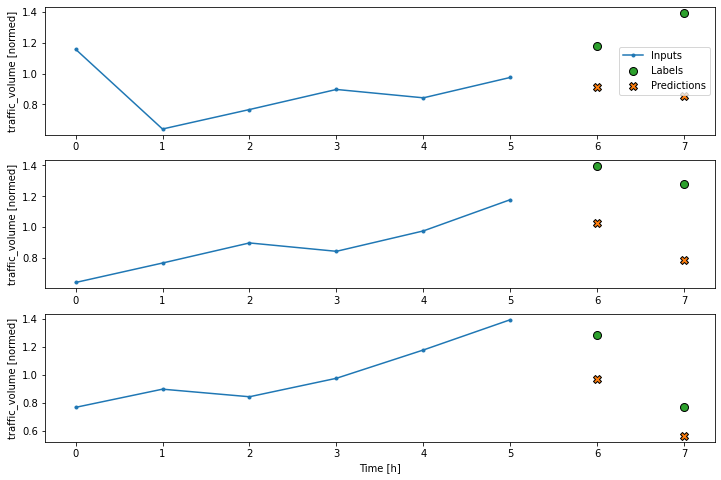

In [25]:
multi_val_performance = {}
multi_performance = {}

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_Base'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM_Base'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### (2) The Base LSTM with parameter Recurrent Dropout (0.1) and dropout layer (0.1)

In this model, the recurrent Dropout with value 0.1 is added into the base model. It is expected to improve the mean absolute error. Recurrent Dropout is a regularization method for recurrent neural networks. Dropout is applied to the updates to LSTM memory cells (or GRU states), i.e. it drops out the input/update gate in LSTM/GRU.

250/250 [==============================] - 1s 2ms/step - loss: 0.7036 - mean_absolute_error: 0.1740


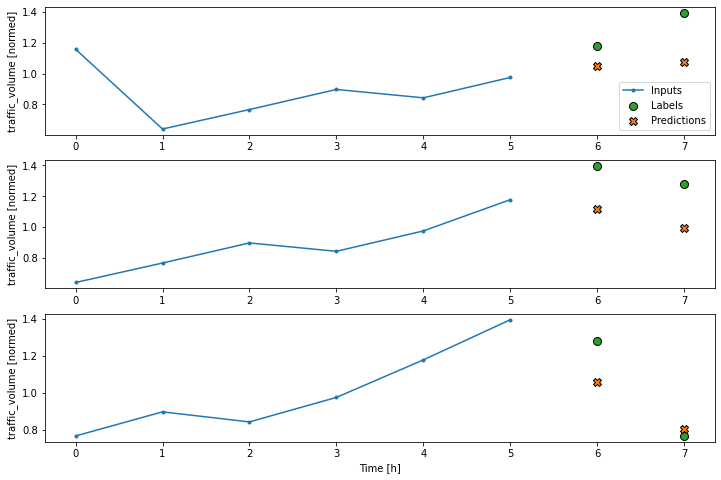

In [26]:
# ns - model with first implementation based on the base 
multi_lstm_model2 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, recurrent_dropout=0.1, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model2, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_ReDropout'] = multi_lstm_model2.evaluate(multi_window.val)
multi_performance['LSTM_ReDropout'] = multi_lstm_model2.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model2)

#### (3) The Base LSTM with parameter Recurrent Dropout (0.1) + unit_forget_bias, and  dropout layer (0.1)

In this model the unit forget bias is added for the experiment. It is hoped that If True, it will add 1 to the bias of the forget gate at initialization. Setting it to true will also force bias_initializer="zeros". The result looks better than the prev ious models. Nevertheless, it is so varying in each run but it seems to capture the minimal MAE.

250/250 [==============================] - 1s 2ms/step - loss: 0.7034 - mean_absolute_error: 0.1742


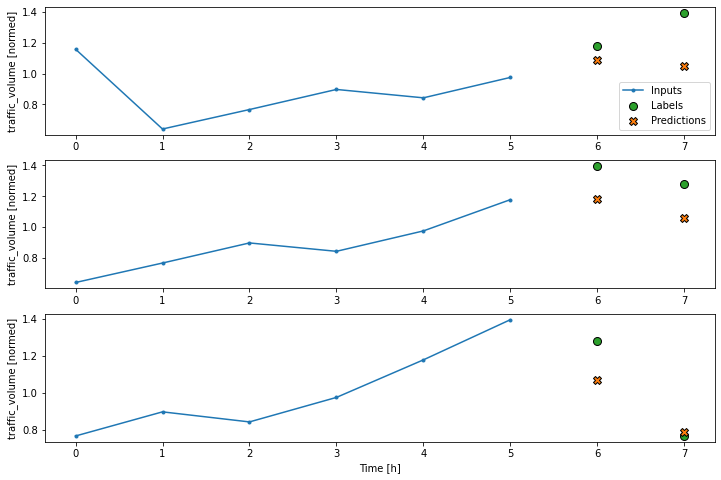

In [27]:
# ns - model with second implementation based on the previous model 
multi_lstm_model3 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, unit_forget_bias=True, recurrent_dropout=0.1, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model3, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_ReDropout2'] = multi_lstm_model3.evaluate(multi_window.val)
multi_performance['LSTM_ReDropout2'] = multi_lstm_model3.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model3)

#### Additional Model
This is an additional model which I tried to tune after I have completed my report. The result is very impressive, so I keep it on this notebook so that I can make the improvement later when I have time. I tried to add the use_bias parameter to the Dense layer. It enables bias vector in this experiment. I want to utilize Gridsearch to this LSTM but time is running out. Therefore, I end up with this best model in terms of lowest MAE of 0.1724.

250/250 [==============================] - 1s 2ms/step - loss: 0.7025 - mean_absolute_error: 0.1724


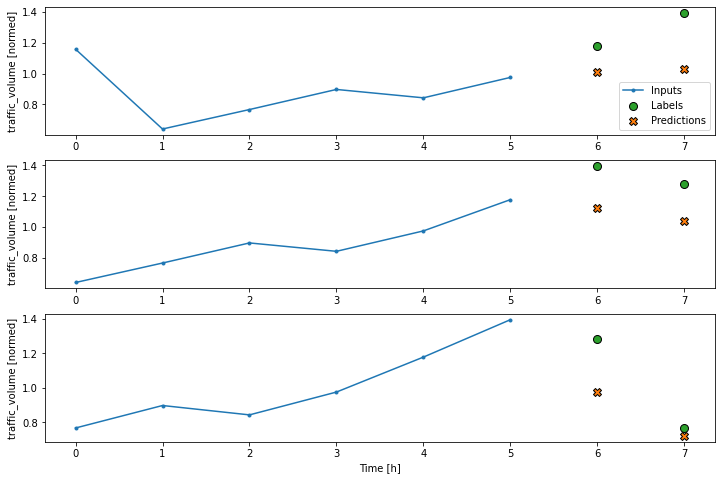

In [47]:
# ns - this is a last minute trial model but it appears efficient
multi_lstm_model9 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, unit_forget_bias=True, recurrent_dropout=0.1, return_sequences=False),
    tf.keras.layers.Dropout(0.1), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), use_bias=True),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model9, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_ReDropout3'] = multi_lstm_model9.evaluate(multi_window.val)
multi_performance['LSTM_ReDropout3'] = multi_lstm_model9.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model9)

#### (4) The GRU Base Model with recurrent_dropout=0.1

GRU is a recurrent neural network (RNN) in the most recent generation, and it is also equivalent to LSTM. In all likelihood, the newer GRU model will outperform the older LSTM model. I started with a simple 32-unit network and a 0.1 recurrence dropout rate.

250/250 [==============================] - 0s 2ms/step - loss: 0.7044 - mean_absolute_error: 0.1798


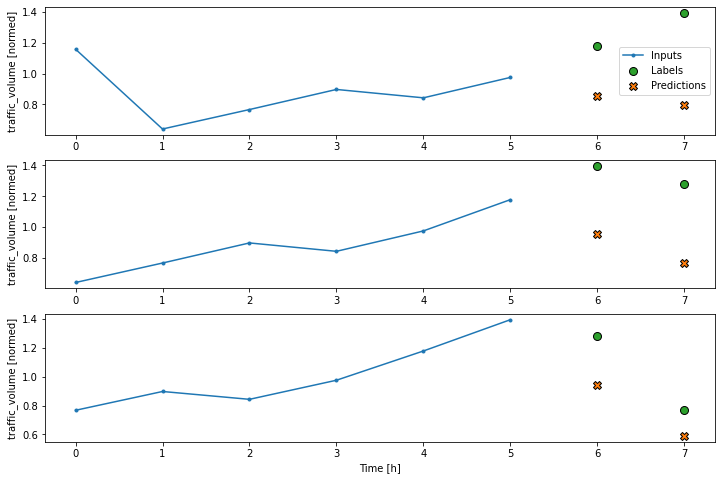

In [28]:
# ns - this model is assigned as the GRU base model
multi_lstm_model4 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, activation='tanh', recurrent_activation='hard_sigmoid', recurrent_dropout=0.1, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model4, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_GRU'] = multi_lstm_model4.evaluate(multi_window.val)
multi_performance['LSTM_GRU'] = multi_lstm_model4.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model4)

#### (5) The GRU Base Model with recurrent_dropout=0.3

250/250 [==============================] - 1s 2ms/step - loss: 0.7050 - mean_absolute_error: 0.1780


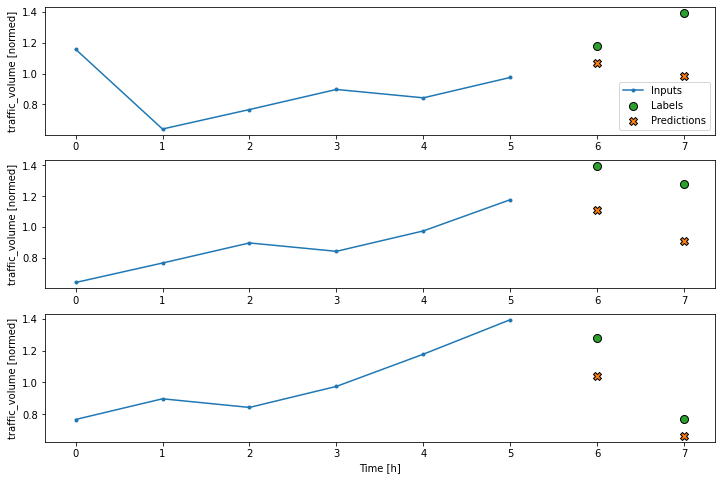

In [29]:
# ns - model with first implementation based on the GRU base 
multi_lstm_model5 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, activation='tanh', recurrent_activation='hard_sigmoid', recurrent_dropout=0.3),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model5, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_GRU2'] = multi_lstm_model5.evaluate(multi_window.val)
multi_performance['LSTM_GRU2'] = multi_lstm_model5.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model5)

#### (6) The GRU Base Model with recurrent_dropout=0.3 and dropout layer (0.1)

In addition to the recurrent dropout parameter, this experiment includes the dropout layer with 0.1 figure which previously demonstrated the better version among dropout varying. The outcome below is quite as anticipated. the MAE becomes better. And again the results are very varying in each run.

250/250 [==============================] - 0s 2ms/step - loss: 0.7064 - mean_absolute_error: 0.1753


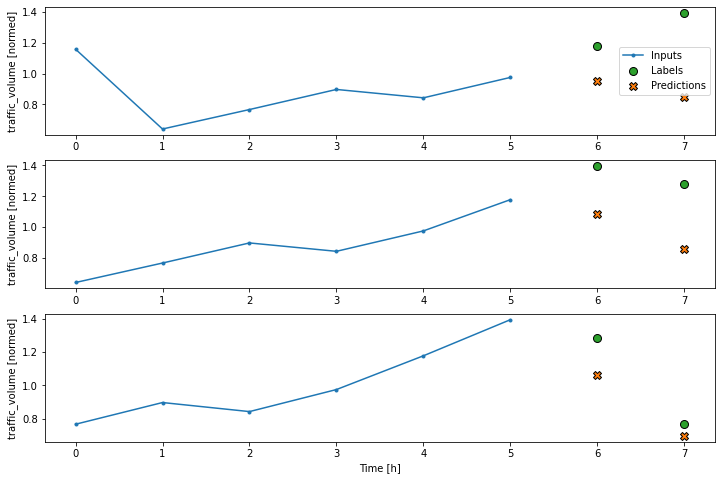

In [30]:
# ns - model with second implementation based on the GRU base 
multi_lstm_model6 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.GRU(32, activation='tanh', recurrent_activation='hard_sigmoid', recurrent_dropout=0.3),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model6, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_GRU3'] = multi_lstm_model6.evaluate(multi_window.val)
multi_performance['LSTM_GRU3'] = multi_lstm_model6.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model6)

#### (7) The Bidirectional Model with LSTM

I proceed with the selection of Bidirectional technique which I wanted to experimenrt with both LSTM and GRU models. It is started with the Bidirectional LSTM in this trial. I believe that allowing the LSTM model to learn the input sequence both forward and backward, and then concatenating both interpretations, can be useful on some sequence prediction challenges. the result looks great but it is not good as I predicted. In each run, it shows unsatisfied value of 1.7

250/250 [==============================] - 1s 2ms/step - loss: 0.7026 - mean_absolute_error: 0.1780


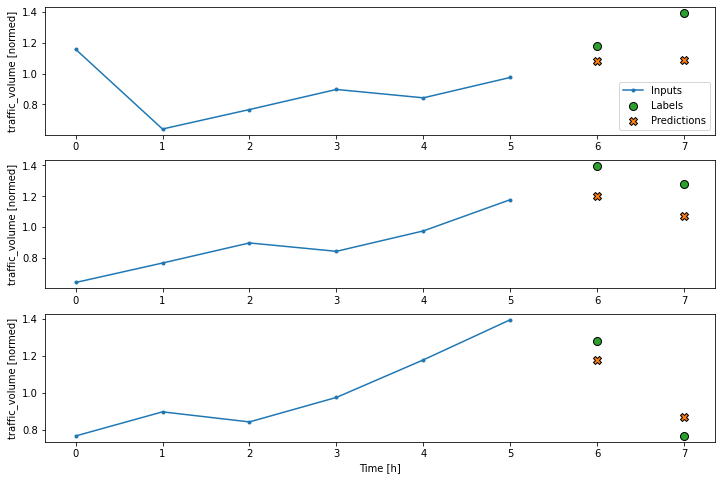

In [31]:
# ns - this model is built to try on Bidirectional with LSTM layer
from keras.layers import Bidirectional
from keras.layers import LSTM

multi_lstm_model7 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, unit_forget_bias=True, 
                                                       recurrent_dropout=0.1, 
                                                       return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model7, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_Bi1'] = multi_lstm_model7.evaluate(multi_window.val)
multi_performance['LSTM_Bi1'] = multi_lstm_model7.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model7)

#### (8) The Bidirectional Model with GRU

The best model of GRU is selected to be the layer of this Bidirectional method. As mentioned ealier, this result also exibits some fluctuation and not high enough as expected.

250/250 [==============================] - 1s 3ms/step - loss: 0.7062 - mean_absolute_error: 0.1799


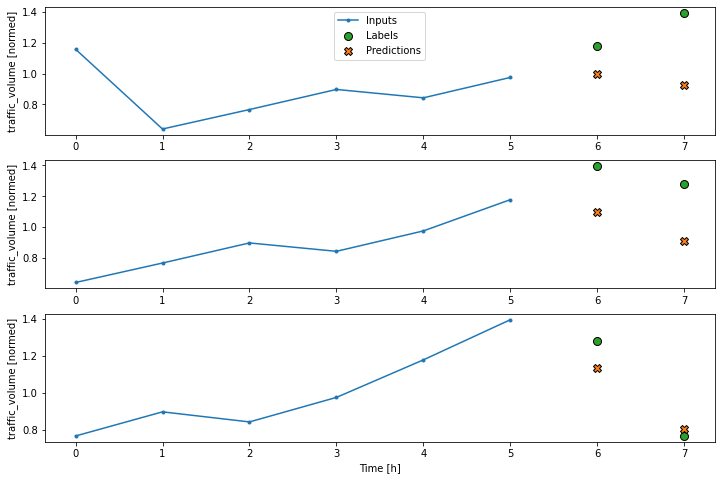

In [32]:
# ns - this model is built to try on Bidirectional with GRU layer
multi_lstm_model7 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, activation='tanh', 
                                                      recurrent_activation='hard_sigmoid', 
                                                      recurrent_dropout=0.1, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model7, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_Bi2'] = multi_lstm_model7.evaluate(multi_window.val)
multi_performance['LSTM_Bi2'] = multi_lstm_model7.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model7)

#### Additional stacked Bidirectional model
This implementation is to show that the more layer I have added into the model the more complex the model would be. This complication diminishes the ability of model. As a result, this experiment proved to be quite weak in comparison with the value of MAE.

250/250 [==============================] - 1s 3ms/step - loss: 0.7129 - mean_absolute_error: 0.1810


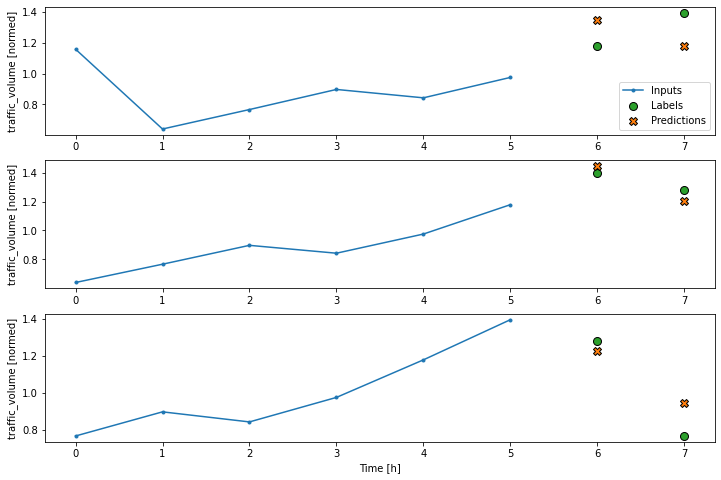

In [108]:
# ns - this model is built to try on Bidirectional with stacked layer
multi_lstm_model10 = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, unit_forget_bias=True, 
                                                       recurrent_dropout=0.1, return_sequences=True)),
    tf.keras.layers.Dropout(0.1), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros(), use_bias=True),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model10, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM_ReDropout10'] = multi_lstm_model10.evaluate(multi_window.val)
multi_performance['LSTM_ReDropout10'] = multi_lstm_model10.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model10)

### Model Prediction and Selection

In [57]:
# ns - The best MAE is 0.1724 which is from model#9 
# ns - Note that every time the kernel is reran, the MAE is varied
prediction = multi_lstm_model9.predict(multi_window.test)
# ns - The shape of prediction
prediction.shape

(4993, 2, 30)

In [58]:
# ns - Extract the traffic volum column which is number 4
predictedValue = prediction[:,1,4]
predictedValue

array([-0.8805853, -0.8099468, -1.167784 , ..., -0.5274453, -0.7348207,
       -0.7859825], dtype=float32)

#### Denormalization

In [59]:
# ns - Extracting the std and mean values
std = train_std[4]
mean = train_mean[4]
print("std: ", std, "mean: ", mean)

std:  1987.0579389711347 mean:  3242.7598852403135


In [60]:
# ns - Performing data conversion to denormalized values
denorm = []
for i in predictedValue:
    val = (i*std)+mean
    denorm.append(val)

#### Export data to CSV file

In [61]:
# ns - dataframe to export raw output to csv file
import pandas as pd
df = pd.DataFrame(denorm, columns = ['prediction'])
df.insert(0, 'id', range(1,4994))
df.to_csv("model9.csv", index = False)

# Thank you!